In [15]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
from typing import Any, Sequence, Optional, Tuple, Iterator, Dict, Callable, Union, Type, List
import numpy as np
import matplotlib.pyplot as plt

# Changing fonts to be latex typesetting
from matplotlib import rcParams
rcParams['mathtext.fontset'] = 'dejavuserif'
rcParams['font.family'] = 'serif'

# # PyTorch for Dataloaders
import torch

# JAX/Flax
import jax
import jax.numpy as jnp
from jax import random
from flax import linen as nn
import wandb

from visualization import visualize as vis
from data import data_functions as df
from models import model_architecture as march
from models import train_model as trm
from models import generate_model as gen

In [35]:
class DoubleDense(nn.Module):
    features: int

    def setup(self):
        self.dense1 = nn.Dense(self.features)
        self.act1 = nn.relu
        self.dense2 = nn.Dense(self.features)
        self.act2 = nn.relu

    def __call__(self, x):
        x = self.dense1(x)
        x = self.act1(x)
        x = self.dense2(x)
        x = self.act2(x)
        return x

class Down(nn.Module):
    features: int

    def setup(self):
        self.dense1 = DoubleDense(self.features)
        self.emb_layer = nn.Dense(self.features)

    def __call__(self, x, t):
        x = self.dense1(x)
        emb = self.emb_layer(t)
        return x + emb


class Up(nn.Module):
    features: int

    def setup(self):
        self.dense1 = DoubleDense(self.features)
        self.emb_layer = nn.Dense(self.features)

    def __call__(self, x, skip_x, t):
        x = jnp.concatenate([skip_x, x], axis=-1)
        x = self.dense1(x)
        emb = self.emb_layer(t)
        return x + emb


class UNet(nn.Module):
    depth: int = 4
    features: Tuple[int] = (64, 128, 256, 512)
    out_feature: int = 2
    std_data: float = 0.5
    embedding_dim: int = 64

    def setup(self):
        self.inc = DoubleDense(self.features[0]) # 2->64
        self.down1 = Down(self.features[1]) # 64->128
        self.down2 = Down(self.features[2]) # 128->256
        self.down3 = Down(self.features[3]) # 256->512

        self.bot1 = DoubleDense(self.features[3]) # 512->512
        self.bot2 = DoubleDense(self.features[3] * 2) # 512->1024
        self.bot3 = DoubleDense(self.features[3]) # 1024->512

        self.up1 = Up(self.features[2]) # 512->256
        self.up2 = Up(self.features[1]) # 256->128
        self.up3 = Up(self.features[0]) # 128->64
        self.outc = nn.Dense(self.out_feature) # 64->2

    def __call__(self, x, t):
        t = t.squeeze()
        c_out = t * self.std_data / jnp.sqrt(self.std_data**2 + t**2)
        c_skip = self.std_data**2 / (self.std_data**2 + t**2)

        # Sampling the noise and embedding the noise via positional encoding
        t = jnp.log(t.flatten()) / 4.
        t = self.pos_encoding(t, self.embedding_dim)
        x_orig = x

        x1 = self.inc(x) # 2 -> 64
        x2 = self.down1(x1, t) # 64 -> 128
        x3 = self.down2(x2, t) # 128 -> 256
        x4 = self.down3(x3, t) # 256 -> 256

        x4 = self.bot1(x4) # 256 -> 512
        x4 = self.bot2(x4) # 512 -> 1024
        x4 = self.bot3(x4) # 1024 -> 512

        x = self.up1(x4, x3, t) # 512 -> 256
        x = self.up2(x, x2, t) # 256 -> 128
        x = self.up3(x, x1, t) # 128 -> 64
        output = self.outc(x) # 64 -> 2

        # Reshape c_out & c_skip to match dimensions for broadcasting
        c_out = jnp.reshape(c_out, (-1,1))
        c_skip = jnp.reshape(c_skip, (-1,1))
        return c_out * output + c_skip * x_orig

    def pos_encoding(self, t, channels):
        t = jnp.expand_dims(t, axis=-1)  # Add an additional dimension to t
        inv_freq = 1.0 / (10000 ** (jnp.arange(0, channels, 2).astype(jnp.float32) / channels))
        pos_enc_a = jnp.sin(t * inv_freq)
        pos_enc_b = jnp.cos(t * inv_freq)
        pos_enc = jnp.concatenate([pos_enc_a, pos_enc_b], axis=-1)
        return pos_enc






# class DoubleDense(nn.Module):
#     features: int

#     def setup(self):
#         self.dense1 = nn.Dense(self.features)
#         self.act1 = nn.relu
#         self.dense2 = nn.Dense(self.features)
#         self.act2 = nn.relu

#     def __call__(self, x):
#         x = self.dense1(x)
#         x = self.act1(x)
#         x = self.dense2(x)
#         x = self.act2(x)
#         return x

# class Down(nn.Module):
#     features: int

#     def setup(self):
#         self.dense1 = DoubleDense(self.features)
#         self.emb_layer = nn.Dense(self.features)

#     def __call__(self, x, t):
#         x = self.dense1(x)
#         emb = self.emb_layer(t)
#         return x + emb


# class Up(nn.Module):
#     features: int

#     def setup(self):
#         self.dense1 = DoubleDense(self.features)
#         self.emb_layer = nn.Dense(self.features)

#     def __call__(self, x, skip_x, t):
#         x = jnp.concatenate([skip_x, x], axis=-1)
#         x = self.dense1(x)
#         emb = self.emb_layer(t)
#         return x + emb


# class UNet(nn.Module):
#     depth: int = 4
#     initial_feature: int = 64
#     out_feature: int = 2
#     std_data: float = 0.5
#     embedding_dim: int = 64

#     def setup(self):
#         # Initial dense layer
#         self.inc = DoubleDense(self.initial_feature) # 2->64

#         # Encoder Block (Downsampling)
#         for i in range(1, self.depth):
#             features = self.initial_feature * (2 ** i)
#             print('Encoder features', features)
#             setattr(self, f'down{i}', Down(features))

#         # Bottleneck Layers
#         bottleneck_features = self.initial_feature * (2 ** (self.depth-1))
#         self.bot1 = DoubleDense(bottleneck_features) # 512->512
#         self.bot2 = DoubleDense(bottleneck_features * 2) # 512->1024
#         self.bot3 = DoubleDense(bottleneck_features) # 1024->512

#         # Decoder Block (Upsampling)
#         for i in reversed(range(0, self.depth-1)):
#             features = self.initial_feature * (2 ** i)
#             print(features)
#             setattr(self, f'up{i}', Up(features))

#         # Final Output Layer
#         self.outc = nn.Dense(self.out_feature)

#     def __call__(self, x, t):
#         # Preconditioning terms
#         t = t.squeeze()
#         c_out = t * self.std_data / jnp.sqrt(self.std_data**2 + t**2)
#         c_skip = self.std_data**2 / (self.std_data**2 + t**2)

#         # Sampling the noise and embedding the noise via positional encoding
#         t = jnp.log(t.flatten()) / 4.
#         t = self.pos_encoding(t, self.embedding_dim)
#         x_orig = x

#         skip_connections = []

#         # Pass through the initial layer
#         x = self.inc(x) # 2 -> 64
#         skip_connections.append(x) # Store the output for skip connection

#         # Pass through the dynamic encoder layers
#         for i in range(1, self.depth):
#             x = getattr(self, f'down{i}')(x, t)
#             skip_connections.append(x) # Store the outputs for skip connections
            
#         # Pass through the bottleneck layers
#         x = self.bot1(x) # 256 -> 512
#         x = self.bot2(x) # 512 -> 1024
#         x = self.bot3(x) # 1024 -> 512

#         # Pass through the dynamic decoder (upsampling) layers
#         for i in reversed(range(0, self.depth-1)):
#             skip_output = skip_connections.pop() # Retrieve last stored output
#             x = getattr(self, f'up{i}')(x, skip_output, t)

#         # Pass through the final output layer
#         output = self.outc(x) # 64 -> 2

#         # Reshape c_out & c_skip to match dimensions for broadcasting
#         c_out = jnp.reshape(c_out, (-1,1))
#         c_skip = jnp.reshape(c_skip, (-1,1))
#         return c_out * output + c_skip * x_orig

#     def pos_encoding(self, t, channels):
#         t = jnp.expand_dims(t, axis=-1)  # Add an additional dimension to t
#         inv_freq = 1.0 / (10000 ** (jnp.arange(0, channels, 2).astype(jnp.float32) / channels))
#         pos_enc_a = jnp.sin(t * inv_freq)
#         pos_enc_b = jnp.cos(t * inv_freq)
#         pos_enc = jnp.concatenate([pos_enc_a, pos_enc_b], axis=-1)
#         return pos_enc

In [36]:
# Generate dataset of 2D Gaussians
X = df.generate_data(43, 20000)
print(X.shape)

# Make the data suitable for a JAX Dataloader
train_dataset = df.JaxDataset(X=X)
train_loader = df.NumpyLoader(dataset=train_dataset,
                              batch_size=128,
                              shuffle=True)
batch = next(iter(train_loader))

# Create random array of noise to instantiate model to print model summary
model = UNet(depth=4,
             features=(64, 128, 256, 512),
             out_feature=2,
             std_data=0.5,
             embedding_dim=64)
#                                   Total Parameters: 3,842,370 (15.4 MB)                                  


# model = UNet(depth=4,
#              initial_feature=64,
#              out_feature=2,
#              std_data=0.5,
#              embedding_dim=64)
# ##                                   Total Parameters: 3,928,386 (15.7 MB)                                  


rng = random.PRNGKey(2)
rnd_normal = random.normal(rng, shape=(batch.shape[0], 1))
t = jnp.exp(rnd_normal * 1.2 - 1.2)
t = t.squeeze()
t = jnp.log(t.flatten()) / 4.

print(model.tabulate(jax.random.PRNGKey(9), batch, t))

(40000, 2)

                                              UNet Summary                                               
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path                ┃ module      ┃ inputs             ┃ outputs           ┃ params                   ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                     │ UNet        │ - float32[128,2]   │ float32[128,2]    │                          │
│                     │             │ - float32[128]     │                   │                          │
├─────────────────────┼─────────────┼────────────────────┼───────────────────┼──────────────────────────┤
│ inc                 │ DoubleDense │ float32[128,2]     │ float32[128,64]   │                          │
├─────────────────────┼─────────────┼────────────────────┼───────────────────┼──────────────────────────┤
│ inc/dense1          │ Dense     

# 3. Training Loop

In [7]:
config = {
    'seed': 47,
    'batch_size': 128,
    'learning_rate': 1e-4,
    'epochs': 20,
    'std_data': 0.5, 
    'depth': 4,
    'features': (64, 128, 256, 512),
    'out_feature': 2,
    'embedding_dim': 64,
    'D': 1024,
    'N': 2
}

# Get the rng & model instantiated
init_rng = random.PRNGKey(config['seed'])
model = UNet(depth=config['depth'],
             features=config['features'],
             out_feature=config['out_feature'],
             std_data=config['std_data'],
             embedding_dim=config['embedding_dim']
)

# Sample the noise distribution
subkey4 = random.PRNGKey(32)
rnd_normal = random.normal(subkey4, shape=(batch.shape[0], 1))
t = jnp.exp(rnd_normal * 1.2 - 1.2)  

# Initialize the models state
state = trm.init_train_state(model=model,
                               random_key=init_rng,
                               x_shape=batch.shape,
                               t_shape=t.shape,
                               learning_rate=config['learning_rate'])

# Call the training function
model, state = trm.train_model(train_loader, model, state, config, wandb_logging=True)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mdowicz. Use `wandb login --relogin` to force relogin


100%|██████████| 20/20 [13:50<00:00, 41.53s/it]


# 4. Sampling Loop

In [8]:
# config = {'std_data': 0.5, 
#           'in_features': 2,
#           'out_features': 2}

# Get the rng & model instantiated
# model = UNet(in_features=config['in_features'],
#              out_features=config['out_features'],
#              std_data=config['std_data'])  

config = {'std_data': 0.5, 
          'depth': 4,
          'features': (64, 128, 256, 512),
          'out_feature': 2,
          'embedding_dim': 64}

model = UNet(depth=config['depth'],
             features=config['features'],
             out_feature=config['out_feature'],
             std_data=config['std_data'],
             embedding_dim=config['embedding_dim']
)

batch = next(iter(train_loader))

updated_model = gen.load_checkpoint(ckpt_dir='PFGMPP/saved_models/toy/checkpoint_20.flax',
                                ckpt_file='checkpoint',
                                model=model)

In [9]:
samples, orig = gen.sample_loop(updated_model,
                                  num_steps=50,
                                  max_t=80,
                                  min_t=0.1,
                                  sample_size=20000,
                                  S_churn=0,
                                  S_min=0.01,
                                  S_max=2,
                                  S_noise=1,
                                  D=2048,
                                  N=2,
                                  rho=7,
                                  std_data=0.5,
                                  key_seed=43)

50it [00:09,  5.48it/s]


# 5. Visualize Generated Data

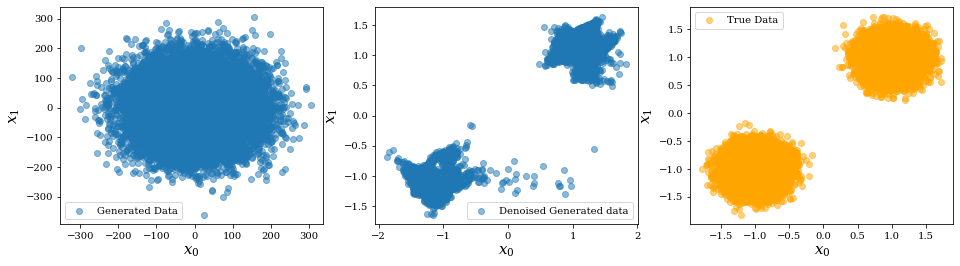

In [10]:
vis.sampling2D(prior_data=orig,
               true_data=X,
               sampled_data=samples,
               std=0.2,
               mean_scale=1)